# Project 2: Pauli channel

# Solution

In [1]:
import numpy as np
from scipy.optimize import fsolve, differential_evolution
from tqdm import tqdm

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.ignis.verification.tomography import StateTomographyFitter

# Plots
import matplotlib.pyplot as plt

## Task 1
An example of a Pauli channel that can't be implemented with the circuit introduced in Project 1, is indeed the eternally non-Markovian channel that we are implementing in this project!

## Task 2

In [2]:
# We have an analytical solution of the system of equations
def theta_from_p(p):
    """ Returns the angles [theta_1, theta_2, theta_3] that implement the Pauli channel with
    probabilities p = [p_1, p_2, p_3]"""
    
    p = np.asarray(p, dtype=complex)
    c = [np.sqrt(1 - np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))/np.sqrt(2),
      np.sqrt(8*p[0]**3 - 4*p[0]**2*(-1 - 6*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) + 
           (1 - 2*p[2])**2*(-1 + 2*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) - 
           2*p[0]*(1 + 4*(p[2] - 3*p[2]**2 - p[2]*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))) + 
                 np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))))/
         (np.sqrt(2)*np.sqrt((-1 + 2*p[0] + 2*p[2])*(4*p[0]**2 + (1 - 2*p[2])**2 + p[0]*(4 + 8*p[2])))),
      np.sqrt((8*p[0]**3 - 4*p[0]**2*(-1 - 6*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) + 
             (1 - 2*p[2])**2*(-1 + 2*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) - 
             2*p[0]*(1 + 4*(p[2] - 3*p[2]**2 - p[2]*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))) + 
                   np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))))/
           (4*p[0]**2 + (1 - 2*p[2])**2 + p[0]*(4 + 8*p[2])))/np.sqrt(-2 + 4*p[0] + 4*p[2])]

    theta = 2*np.arccos(np.real(c))
    return theta

In [3]:
def pauli_channel(q, p, system, pauli_ancillae):
    """
        Apply the Pauli channel to system with probabilities p
        
    Args:
    q (QuantumRegister): the quantum register for the circuit
    system (int): index of the system qubit
    pauli_ancillae (list): list of indices of the ancillary qubits
    p (list): list of probabilities [p_1, p_2, p_3] for the Pauli channel
    
    Returns:
    A QuantumCircuit implementing the Pauli channel
    """
    
    theta = theta_from_p(p)
    
    dc = QuantumCircuit(q)
    dc.ry(theta[0], q[pauli_ancillae[0]])
    dc.cx(q[pauli_ancillae[0]], q[pauli_ancillae[1]])
    dc.ry(theta[1], q[pauli_ancillae[0]])
    dc.ry(theta[2], q[pauli_ancillae[1]])

    dc.cx(q[pauli_ancillae[0]], q[system])
    dc.cy(q[pauli_ancillae[1]], q[system])

    return dc

## Task 3

By using the suggested imports, the functions `conditional_entropy` and `extractable_work` are actually
one-liners...

In [4]:
from qiskit.tools.qi.qi import entropy, partial_trace

def conditional_entropy(state, qubit_a, qubit_b):
    """Conditional entropy S(A|B) = S(AB) - S(B)
    
    Args:
        state: a vector or density operator
        qubit_a: 0-based index of the qubit A
        qubit_b: 0-based index of the qubit B
        
    Returns:
        int: the conditional entropy
    """
    return entropy(state) - entropy(partial_trace(state, [qubit_b]))

def extractable_work(state, system_qubit, memory_qubit, n=1):
    """Extractable work from a two-qubit state
    =
    Cfr. Eq. (3-4) Bylicka et al., Sci. Rep. 6, 27989 (2016)
    
    Args:
        qubit_a: 0-based index of the system qubit S
        qubit_b: 0-based index of the memory qubit M
    """
    return (n - conditional_entropy(state, system_qubit, memory_qubit)/np.log(2))

## Task 4
First of all, we define the function returning the probabilities as function of time:

In [5]:
def p_enm(t, eta=1., omega=1.):
    p = [1/4 * (1 - np.exp(-2 * t *eta)), 
         1/4 * (1 - np.exp(-2 * t *eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 *np.exp(-t *eta) * np.cosh(t *omega))]
    return p

def p_ncp(t, eta=1., omega=1.):
    p = [1/4 * (1 - np.exp(-2 * t *eta)), 
         1/4 * (1 - np.exp(-2 * t *eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 *np.exp(-t *eta) * np.cos(t *omega))]
    return p

In [6]:
# Here are the parameters
t_values = np.linspace(0, 3, 11)

# Parameters
params_ncp = {'eta': 0.1, 'omega': 2.0}
params_enm = {'eta': 1.0, 'omega': .5}

# And the qubit assignments
SHOTS = 8192

q = QuantumRegister(5, name='q')
c = ClassicalRegister(2, name='c')

system = 2
ancilla = 4

pauli_ancillae = [0, 1]

The state preparation circuit

In [7]:
# Prepare the two qubits 0 and 2 in a psi- state
prepare_two_qubit = QuantumCircuit(q)

prepare_two_qubit.x(q[ancilla])
prepare_two_qubit.x(q[system])
prepare_two_qubit.h(q[ancilla])
prepare_two_qubit.cx(q[ancilla], q[system]) 
prepare_two_qubit.barrier()

And finally the simulation of the Pauli channel

100%|██████████| 11/11 [00:04<00:00,  2.51it/s]


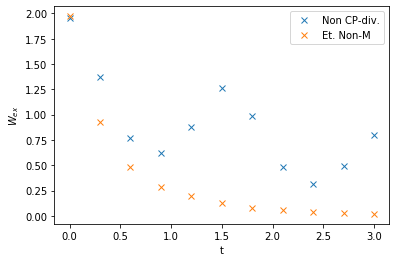

In [9]:
wext_ncp = []

for t in tqdm(t_values):
    circ = prepare_two_qubit + pauli_channel(q, p_ncp(t, **params_ncp), system, pauli_ancillae)
    tomo_circuits_ncp = state_tomography_circuits(circ, [q[ancilla], q[system]])

    job = execute(tomo_circuits_ncp, Aer.get_backend('qasm_simulator'), shots=SHOTS)
    result = job.result()
    
    tomo_fitter = StateTomographyFitter(result, tomo_circuits_ncp)
    rho = tomo_fitter.fit()
    
    wext_ncp.append(extractable_work(rho, 1, 0))

wext_enm = []

for t in tqdm(t_values):
    circ = prepare_two_qubit + pauli_channel(q, p_enm(t, **params_enm), system, pauli_ancillae)
    tomo_circuits_enm = state_tomography_circuits(circ, [q[ancilla], q[system]])

    job = execute(tomo_circuits_enm, Aer.get_backend('qasm_simulator'), shots=SHOTS)
    result = job.result()
    
    tomo_fitter = StateTomographyFitter(result, tomo_circuits_enm)
    rho = tomo_fitter.fit()
    
    wext_enm.append(extractable_work(rho, 1, 0))
    
plt.plot(t_values, wext_ncp, 'x', label='Non CP-div.')
plt.plot(t_values, wext_enm, 'x', label='Et. Non-M')
plt.legend()
plt.xlabel('t')
plt.ylabel('$W_{ex}$');